Библиотеки

In [11]:
import torch
from torch.utils.data import DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
from datasets import load_dataset
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


Загрузка датасета

In [13]:
dataset = load_dataset("imdb")
print(dataset.shape)
print(dataset["test"][0])


{'train': (25000, 2), 'test': (25000, 2), 'unsupervised': (50000, 2)}
{'text': 'I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star Trek (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, CG that doesn\'t match the background, and painfully one-dimensional characters cannot be overcome with a \'sci-fi\' setting. (I\'m sure there are those of you out there who think Babylon 5 is good sci-fi TV. It\'s not. It\'s clichéd and uninspiring.) While US viewers might like emotion and character development, sci-fi is a genre that does not take itself seriously (cf. Star Trek). It may treat important issues, yet not as a serious philosophy. It\'s really difficult to care about the characters here as they are not simply foolish, just missing a spark of life. Their actions and reactions are wooden and predictab

Выбор токенизатора и токенизация

In [14]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)


def tokenize_function(example):
    return tokenizer(
        example["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

tokenized_dataset = dataset.map(tokenize_function, batched=True)

print(tokenized_dataset["test"].shape, tokenized_dataset["test"][0])


(25000, 5) {'text': 'I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star Trek (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, CG that doesn\'t match the background, and painfully one-dimensional characters cannot be overcome with a \'sci-fi\' setting. (I\'m sure there are those of you out there who think Babylon 5 is good sci-fi TV. It\'s not. It\'s clichéd and uninspiring.) While US viewers might like emotion and character development, sci-fi is a genre that does not take itself seriously (cf. Star Trek). It may treat important issues, yet not as a serious philosophy. It\'s really difficult to care about the characters here as they are not simply foolish, just missing a spark of life. Their actions and reactions are wooden and predictable, often painful to watch. The makers of Earth KNOW it\'s 

Подготовка данных для торча

In [15]:
tokenized_dataset = tokenized_dataset.remove_columns(["text"])
tokenized_dataset.set_format("torch")

Маленькая подвыборка данных для адекватного времени обучения

In [16]:
small_train = tokenized_dataset["train"].shuffle(seed=42).select(range(3000))
small_test = tokenized_dataset["test"].shuffle(seed=42).select(range(1000))

print(small_train.shape, small_train[0])

(3000, 4) {'label': tensor(1), 'input_ids': tensor([  101,  2045,  2003,  2053,  7189,  2012,  2035,  2090,  3481,  3771,
         1998,  6337,  2099,  2021,  1996,  2755,  2008,  2119,  2024,  2610,
         2186,  2055,  6355,  6997,  1012,  6337,  2099,  3504, 15594,  2100,
         1010,  3481,  3771,  3504,  4438,  1012,  6337,  2099, 14811,  2024,
         3243,  3722,  1012,  3481,  3771,  1005,  1055,  5436,  2024,  2521,
         2062,  8552,  1012,  1012,  1012,  3481,  3771,  3504,  2062,  2066,
         3539,  8343,  1010,  2065,  2057,  2031,  2000,  3962, 12319,  1012,
         1012,  1012,  1996,  2364,  2839,  2003,  5410,  1998,  6881,  2080,
         1010,  2021,  2031,  1000, 17936,  6767,  7054,  3401,  1000,  1012,
         2111,  2066,  2000, 12826,  1010,  2000,  3648,  1010,  2000, 16157,
         1012,  2129,  2055,  2074,  9107,  1029,  6057,  2518,  2205,  1010,
         2111,  3015,  3481,  3771,  3504,  2137,  2021,  1010,  2006,  1996,
         2060,  2192

Инициализация моделей

In [17]:
from torch.optim import AdamW

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
)

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir="./logs"
)

trainer = Trainer(
    model=model,
    args=training_args,
    optimizers=(AdamW(params=model.parameters(), lr=2e-5), None),
    train_dataset=small_train,
    eval_dataset=small_test,
)

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
`logging_dir` is deprecated and will 

Обучение и оценка

In [18]:
trainer.train()
results = trainer.evaluate()
print(results)

D:\дз\нейронки\Transformers\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch,Training Loss,Validation Loss
1,No log,0.425996


Epoch,Training Loss,Validation Loss
1,No log,0.425996
2,0.368977,0.520245


D:\дз\нейронки\Transformers\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch,Training Loss,Validation Loss
1,No log,0.425996
2,0.368977,0.520245


D:\дз\нейронки\Transformers\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


{'eval_loss': 0.520245373249054, 'eval_runtime': 76.4017, 'eval_samples_per_second': 13.089, 'eval_steps_per_second': 1.636, 'epoch': 2.0}


Тест

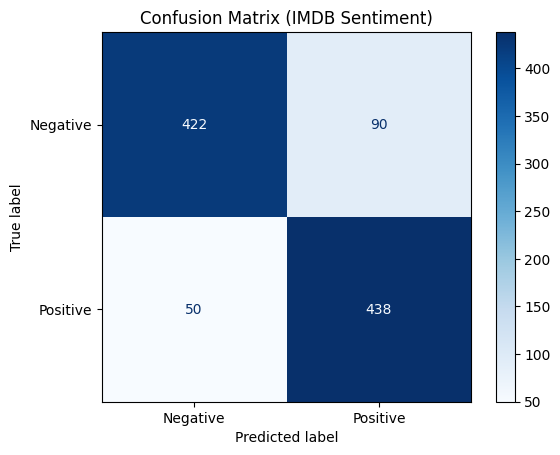

In [19]:
predictions = trainer.predict(small_test)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Negative", "Positive"]
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (IMDB Sentiment)")
plt.show()


Предсказание на примере

In [20]:
text = "This movie was absolutely fantastic!"
inputs = tokenizer(text, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

prediction = torch.argmax(outputs.logits, dim=1)
print("Positive" if prediction.item() == 1 else "Negative")


Positive
